# Automated 3D Reconstruction from Satellite Images
##  _SIAM IS18 MINITUTORIAL - 08/06/2018_
### Gabriele Facciolo, Carlo de Franchis, and Enric Meinhardt-Llopis


<table>
  <tr>
    <th><img src="https://gfacciol.github.io/IS18/step1_150.png"></th>
    <th><img src="https://gfacciol.github.io/IS18/step2_150.png"></th>    
    <th><img src="https://gfacciol.github.io/IS18/step3_150.png"></th>    
    <th><img src="https://gfacciol.github.io/IS18/step4_150.png"></th>
  </tr>
</table>


-----------------------------------------------------


This tutorial is a hands-on introduction to the manipulation of optical satellite images. The objective is to provide all the tools needed to process and exploit the images for 3D reconstruction. We will present the essential modeling elements needed for building a stereo pipeline for satellite images. This includes the specifics of satellite imaging such as pushbroom sensor modeling, coordinate systems, and localization functions. 


This notebook is divided in three sections.

1. **Coordinate Systems and Geometric Modeling of Optical Satellites.** Introduces geographic coordinates,  and sensor models needed to manipulate satellite images. 
2. **Epipolar Rectification and Stereo Matching.** Introduces an approximated sensor model which is used to rectify pairs of satellite images and compute correspondences between them.
3. **Triangulation and Digital Elevation Models.** Creates a point cloud by triangulating the correspondences then projects them on an UTM reference system.


First we setup the tools needed for rest of the notebook.

<b><span style="color:blue;background:yellow">Jupyter notebook usage: press <span style="color:black">SHIFT+ENTER</span> to run one cell and go to the next one</span></b></div>

In [1]:
# Standard modules used through the notebook 
import numpy as np
import matplotlib.pyplot as plt

# Tools specific for this tutorial
# They are in the .py files accompaining this notebook 
import vistools      # display tools
import utils         # IO tools
import srtm4         # SRTM tools
import rectification # rectification tools
import stereo        # stereo tools
import triangulation # triangulation tools
from   vistools import printbf   # boldface print

# Display and interface settings (just for the notebook interface)
%load_ext autoreload
%autoreload 2
%matplotlib inline
np.set_printoptions(linewidth=150)

# Section 1. Coordinate Systems and Geometric Modeling


In this first section we'll learn:

* about geodetic (longitude, latitude)  and projected (UTM) coordinates 
* to manipulate large satellite images 
* RPC camera model for localization and projection

-----------------------------------------------------

## Coordinate systems

Coordinate reference systems (CRS) provide a standardized way of describing geographic locations.
Determining the shape of the earth is the first step in developing a CRS.
A natural choice for describing points in 3d relative to the **ellipsoid**, is using [latitude, longitude, and altitude](https://en.wikipedia.org/wiki/World_Geodetic_System#A_new_World_Geodetic_System:_WGS_84). These are unprojected (or geographic) reference systems. 
Projected systems, on the other hand, are used for referencing locations on 2d
representations of the Earth. 



<img style="float: right; width:200px;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8c/Latitude_and_longitude_graticule_on_an_ellipsoid.svg/200px-Latitude_and_longitude_graticule_on_an_ellipsoid.svg.png"/>


#### Geodetic Longitude, Latitude, and WGS84

The [World Geodetic System (WGS84)](https://en.wikipedia.org/wiki/World_Geodetic_System#WGS84) is a standard for use in cartography, geodesy, navigation, GPS. It comprises a standard coordinate system for the Earth, a standard  reference ellipsoid to express altitude data, and a gravitational equipotential surface (the geoid) that defines the nominal sea level.  

- [The geodetic latitude](https://en.wikipedia.org/wiki/Latitude)
(usually denoted as φ) is the **angle between the equatorial plane** and a line that is **normal to the reference ellipsoid**.
Note that the normal to the ellipsoid does not pass through the center, except at the equator and at the poles. 
- [The longitude](https://en.wikipedia.org/wiki/Longitude) of a point on Earth's surface is the angle east or west of a reference Greenwich meridian to another meridian that passes through that point. 



<table style="float: right;" >
  <tr>
    <th>
<img style="float: center;"  width="150px"  src="https://upload.wikimedia.org/wikipedia/commons/f/f4/Mercator_projection_SW.jpg" />
    </th>
    <th>
<img style="float: center;"  width="200px"  src="https://upload.wikimedia.org/wikipedia/commons/e/e2/Cylindrical_Projection_basics2.svg" />
    </th>
  </tr>
</table>

#### Projections: Mercator and UTM

Projections transform the elliptical earth into a flat surface.
It is impossible to flatten a round object
without distortion. This results in trade-offs between area,
direction, shape, and distance. 


- [**The Mercator projection**](https://en.wikipedia.org/wiki/Mercator_projection) (used in Google maps) is a cylindrical map projection that is conformal so it preserves angles (which is usefull for navigation).
The Mercator projection does not preserve areas, but **it is most accurate around the equator, where it is tangent to the globe**. 



<img style="float: right;"  width="300px"         src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8a/Transverse_mercator_graticules.svg/800px-Transverse_mercator_graticules.svg.png" />

- [**The Universal Transverse Mercator (UTM)**](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system) system is not a single map projection. The system instead divides the Earth into sixty **zones, each being a six-degree band of longitude**, and uses a secant transverse Mercator projection in each zone. 
Within an UTM zone the coordinates are expressed as easting and northing.
The **easting** coordinate refers to the eastward-measured distance (in meters) from the central meridian of the UTM zone. While the **northing** coordinate refers to the distance to the equator. The northing of a point south of the equator is equal to 10000000m minus its distance from the equator (this way there are no negative coordinates).

### Data available for this tutorial

Since high-resolution WorldView-3 images are not in general freely downloadable (you have to buy them), a [sample set of publicly available images](http://www.jhuapl.edu/pubgeo/satellite-benchmark.html) is provided in a remote folder. The content of that folder can be listed with the `listFD` function of the `utils` module.

In [2]:
# list the tiff images available in the remote folder
IARPAurl = 'http://menthe.ovh.hw.ipol.im:80/IARPA_data/cloud_optimized_geotif'
myimages = utils.listFD(IARPAurl, 'TIF')

# sort the images by acquisition date
myimages = sorted(myimages, key=utils.acquisition_date)
print('Found {} images'.format(len(myimages)))

# select the two images to start working
idx_a, idx_b = 0, 5
print("Images Used:")
print(myimages[idx_a])
print(myimages[idx_b])

Found 50 images
Images Used:
http://menthe.ovh.hw.ipol.im:80/IARPA_data/cloud_optimized_geotif/15NOV14WV031000014NOV15135121-P1BS-500171606160_05_P005_________AAE_0AAAAABAABC0.TIF
http://menthe.ovh.hw.ipol.im:80/IARPA_data/cloud_optimized_geotif/11FEB15WV031000015FEB11135123-P1BS-500497282030_01_P001_________AAE_0AAAAABPABR0.TIF


### Images geographic footprints

The longitude, latitude bounding box of a GeoTIFF image is described in its metadata. The `get_image_longlat_polygon` of the `utils` module can read it. Let's use it to display on a map the footprints of the selected images.

In [3]:
# creates an interactive map and returns a map handle to interact with it.
mymap = vistools.clickablemap(zoom=12)
display(mymap)

# display the footprint polygons of the satellite images 
for f in [idx_a, idx_b]:
    
    footprint = utils.get_image_longlat_polygon(myimages[f])
    mymap.add_GeoJSON(footprint)

# center the map on the center of the footprint
mymap.center = np.mean(footprint['coordinates'][0][:4], axis=0).tolist()[::-1]

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

## Coordinates of the area of interest (AOI)

In [4]:
## set the coordinates of the area of interest as a GeoJSON polygon
# Buenos aires AOI
aoi_buenos_aires = {'coordinates': [[[-58.585185, -34.490883],
   [-58.585185, -34.48922],
   [-58.583104, -34.48922],
   [-58.583104, -34.490883],
   [-58.585185, -34.490883]]],
 'type': 'Polygon'}
# add center field
aoi_buenos_aires['center'] = np.mean(aoi_buenos_aires['coordinates'][0][:4], axis=0).tolist()
    
# add a polygon and center the map
mymap.add_GeoJSON(aoi_buenos_aires)  # this draws the polygon described by aoi
mymap.center = aoi_buenos_aires['center'][::-1]  # aoi_buenos_aires['coordinates'][0][0][::-1] 
mymap.zoom = 15

## Geometric modeling of optical satellites

### The Rational Polynomial Camera Model

Image vendors usually provide the orientation parameters of the cameras along with the images.
To save their customers the tedious task of understanding and
implementing each specific geometric camera model, they provide instead the *localization* and *projection* functions $L$ and $P$ associated to each image.
These functions allow converting from image coordinates to coordinates
on the globe and back. 

- The projection function $P:\mathbb{R}^3\to\mathbb{R}^2$,
$(\lambda, \theta, h) \mapsto \textbf{x}$ returns the image coordinates, in pixels, of a given 3-space
point represented by its spheroidal coordinates in the World Geodetic
System (WGS 84) identified by its
longitude, latitude and
altitude $h$ (in meters) above the reference ellipsoid. 

- The localization function $L:\mathbb{R}^3\to\mathbb{R}^2$, $(\textbf{x}, h) \mapsto (\lambda, \theta)$ is its
inverse with respect to the first two components. It takes a point $\textbf{x}
= (x, y)^\top$ in the image domain together with an altitude $h$, and
returns the geographic coordinates of the unique 3-space point
$\textbf{X} = (\lambda, \theta, h)$.

<!-- <img src="fig/Latitude_and_Longitude_of_the_Earth.svg" alt="Longitude and latitude" style="width: 400px"/>-->

<img src="fig/rpc_illustration.svg" alt="Projection and localization functions" style="width: 300px; float:right"/>

***The *Rational Polynomial Coefficient* ($\scriptsize{\text{RPC}}$) camera model is an
analytic description of the projection and localization functions*** [(Baltsavias & Stallmann'92)](http://dx.doi.org/10.3929/ethz-a-004336038), [(Tao & Hu'01)](http://eserv.asprs.org/PERS/2001journal/dec/2001_dec_1347-1357.pdf). Projection and
localization functions are expressed as ratio of multivariate cubic
polynomials. 
For example, the latitude component of the localization
function for the image point $(x, y)$ at altitude $h$ is

\begin{equation}
\theta = \frac{\sum_{i=1}^{20} C^{\theta, \tiny{\text{NUM}}}_i \rho_i(x, y, h)}{\sum_{i=1}^{20} C^{\theta, \tiny{\text{DEN}}}_i \rho_i(x, y, h)}
\end{equation}

where $C^{\theta, \tiny{\text{NUM}}}_i$ (resp.
$C^{\theta, \tiny{\text{DEN}}}_i$) is the $i^{\text{th}}$ coefficient of the
numerator (resp. denominator) polynomial and $\rho_{i}$ produces the
$i^{\text{th}}$ factor of the three variables cubic polynomial. 
A cubic polynomial in three variables has 20 coefficients, thus each
component of the localization and projection functions requires 40
coefficients. Ten additional parameters specify the scale and
offset for the five variables $x, y, \lambda, \theta$ and $h$. 


$\scriptsize{\text{RPC}}$ localization and projection functions
are not exact inverses of each other. The errors due to
concatenating the projection and inverse functions are negligible, being
of the order of $10^{-7}$ degrees in longitude and latitude, i.e. about 1 cm
on the ground or $\frac{1}{100}$ of pixel in the image.

### Images RPC coefficients

The 90 coefficients (20 \* 2 \* 2 + 10) of the RPC projection function associated to each image are stored in the image GeoTIFF header. They can be read with the `rpc_from_geotiff` function of the `utils` module. This function returns an instance of the class `rpc_model.RPCModel` which contains the RPC coefficients and a `projection` method.

In [5]:
myrpcs = [utils.rpc_from_geotiff(x) for x in myimages]
rpc = myrpcs[idx_a]
print(rpc)

# let's try the projection method
lon, lat = aoi_buenos_aires['center']
x, y = rpc.projection(lon, lat, 0)
print("\n\nThe pixel coordinates (in image idx_a) of our AOI center\n"
      "(lon=%.4f, lat=%.4f) at altitude 0 are: (%f, %f)" % (lon, lat, x, y))


    # Projection function coefficients
      col_num =  0.0031 -1.0153  0.0002  0.0079 -0.0032 -0.0004 -0.0002 -0.0021  0.0000  0.0000 -0.0000  0.0000  0.0002  0.0000 -0.0000 -0.0003 -0.0000 -0.0000  0.0000 -0.0000
      col_den =  1.0000  0.0010 -0.0033 -0.0004  0.0000 -0.0000 -0.0000 -0.0000  0.0001 -0.0000 -0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
      row_num = -0.0116 -0.0222  1.0376 -0.0143  0.0014 -0.0000  0.0007 -0.0003  0.0088 -0.0000  0.0000  0.0000  0.0000  0.0000 -0.0001 -0.0002 -0.0001  0.0000  0.0000  0.0000
      row_den =  1.0000 -0.0017  0.0029 -0.0009 -0.0000 -0.0000 -0.0000 -0.0000  0.0002 -0.0001 -0.0000  0.0000  0.0000  0.0000  0.0000  0.0001  0.0000  0.0000 -0.0000  0.0000

    # Offsets and Scales
      row_offset = 14359.0
      col_offset = 13615.0
      lat_offset = -34.4754
      lon_offset = -58.611
      alt_offset = 31.0
      row_scale = 14360.0
      col_scale = 13617.0
      lat_scale = 0.0688
      lon_scale = 0.

### **<span style="color:red">Exercise 1** 
<span style="color:red">Complete the implementation of the `crop_aoi` function below. This function crops an area of interest (AOI) defined with geographic coordinates in a GeoTIFF image using its RPC functions.</span>

It takes as input arguments:
* `geotiff`: path to the input GeoTIFF image file
* `aoi`: GeoJSON polygon
* `z`: ground altitude with respect to the WGS84 ellipsoid

It returns:
* `crop`: a numpy array containing the image crop
* `x, y`: integer pixel coordinates of the top left corner of the crop in the input image

To complete this function you need to use:
* `utils.rpc_from_geotiff` to read the RPC coefficients and get an `rpc_model.RPCModel` object
* the `projection` method of the `rpc_model.RPCModel` object
* `utils.bounding_box2D` to compute a horizontal/vertical rectangular bounding box
* `utils.rio_open` to open the image with the `rasterio` package
* the `read(window=())` method of a `rasterio` object to read a window of the image


The `projection` function needs an altitude coordinate `z`, which **is not** contained in the `aoi` GeoJSON polygon. We may **assume that `z` is zero**, or alternatively **get `z` from an external Digital Elevation Model (DEM) such as SRTM**. The SRTM altitude at a given `longitude, latitude` obtained using the `srtm4` module.


**The code below calls your `crop_aoi` function** to crop the area selected in the map from image idx_a and displays the crop. The altitude is evaluated using the the `srtm4` function. Vefify that the image corresponds to the area selected  above.

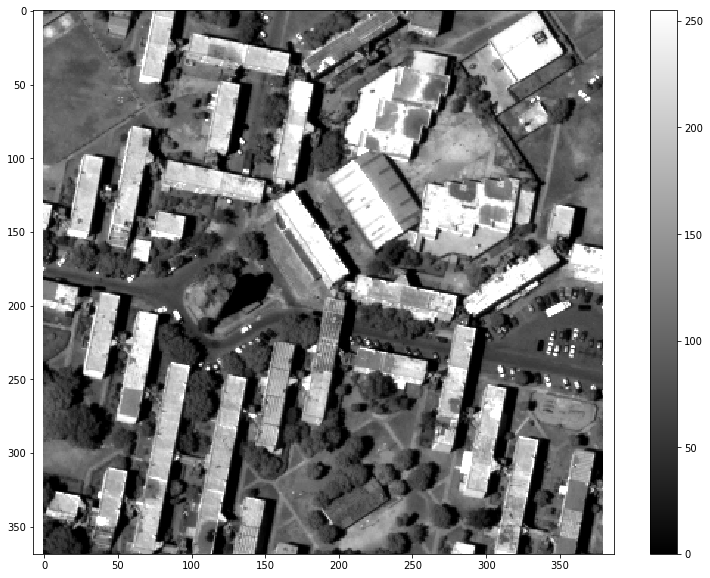

In [7]:
def crop_aoi(geotiff, aoi, z=0):
    """
    Crop a geographic AOI in a georeferenced image using its RPC functions.

    Args:
        geotiff (string): path or url to the input GeoTIFF image file
        aoi (geojson.Polygon): GeoJSON polygon representing the AOI
        z (float): base altitude with respect to WGS84 ellipsoid (0 by default)

    Return:
        bbox: x, y, w, h image coordinates of the crop. x, y are the
            coordinates of the top-left corner, while w, h are the dimensions
            of the crop.
    """
    # extract the rpc from the geotiff file
    rpc = utils.rpc_from_geotiff(geotiff)
    # put the aoi corners in an array
    Clonlat = np.array(aoi['coordinates'][0])             # 4 coordinates (lon,lat)

    # project Clonlat into the image
    # INSERT A LINE FOR COMPUTING THE FOUR x,y IMAGE COORDINATES  
    # STARTING FROM THE longitude and latitude in: Clonlat[:,0] Clonlat[:,1]    
    x, y = rpc.projection(Clonlat[:,0], Clonlat[:,1], z)

    # convert the list into array
    pts = np.array([x, y])                          # all coordinates (pixels)
    # compute the bounding box in pixel coordinates
    bbox = utils.bounding_box2D(pts.transpose())
    x0, y0, w, h = np.round(bbox).astype(int)
    # crop the computed bbox from the large GeoTIFF image
    with utils.rio_open(geotiff, 'r') as src:
        crop = src.read(window=((y0, y0 + h), (x0, x0 + w)))
    return crop, x0, y0



# get the altitude of the center of the AOI
lon, lat  = aoi_buenos_aires['center']
z = srtm4.srtm4(lon, lat)

# crop the selected AOI in image number 10
crop, x, y = crop_aoi(myimages[idx_a], aoi_buenos_aires, z)

# display the crop
vistools.display_imshow(utils.simple_equalization_8bit(crop))

### Localization function

The _localization_ function is the inverse of the _projection_ function with respect to the image coordinates. It takes as input a triplet `x, y, z`, where `x` and `y` are pixel coordinates and `z` is the altitude of the corresponding 3D point above the WGS84 ellipsoid. It returns the longitude `lon` and latitude `lat` of the 3D point.

The code below projects a 3D point on the image, localizes this image point on the ground, and then **computes the distance to the original point**.

In [ ]:
from  numpy.linalg import norm as l2norm
# get the altitude of the center of the AOI
z = srtm4.srtm4(lon, lat)

# project a 3D point on the image
x, y = rpc.projection(lon, lat, z)

# localize this image point on the ground
new_lon, new_lat = rpc.localization(x, y, z)

# compute the distance to the original point
print( "Error of the inverse: {} pixels".format( l2norm([new_lon - lon, new_lat - lat]) ) )

# Section 2. Epipolar Rectification and Stereo Matching

In this section we will learn to compute correspondences between a pair of images.
These correspondences will be used in the next section for computing 3D models.

The basic scheme is the following:
1. extract, rotate, rescale, and shear a portion of each image so that epipolar lines are horizontal and coincident 
2. apply a standard stereo-matching algorithm such as SGM using a robust matching cost
-----------------------------------------------------

### Epipolar curves

The following illustration displays the epipolar curve corresponding to a point in the first image. 
The function samples the epipolar curve of a pair of images by composing the _localization_ function of the first image with the _projection_ function of the second image.

**Note that the resulting line is practically a straight line!**

In [ ]:
rectification.trace_epipolar_curve(myimages[37], myimages[38], aoi_buenos_aires, x0=220, y0=200)

### Affine approximation of the camera model

Let $P: \mathbb{R}^3\longrightarrow \mathbb{R}^2$ be the _projection_ function. The first order Taylor approximation of $P$ around point $X_0$ is $P(X) = P(X_0) + \nabla P(X_0)(X - X_0)$, which can be rewritten as

$$
P(X) = \nabla P(X_0)X + T
$$

with $\nabla P(X_0)$ the jacobian matrix of size (2, 3) and $T = P(X_0) - \nabla P(X_0) X_0$ a vector of size 2. This can be rewritten as a linear operation by using homogeneous coordinates: with $X = (\lambda, \varphi, h, 1)$ the previous formula becomes $P(X) = AX$, where the (3, 4) matrix $A$ is the _affine approximation_ of the RPC _projection_ function $P$ at point $X_0$. 

The code below calls the `rpc_affine_approximation` function to compute the affine camera matrix approximating the RPC _projection_ function around the center $X_0$ of the area selected in the map. Then it evaluates the approximation error away from the center.

In [ ]:
# get the altitude of the center of the AOI
lon, lat = aoi_buenos_aires['center']
z = srtm4.srtm4(lon, lat)

# compute the affine projection matrix 
A = rectification.rpc_affine_approximation(rpc, (lon, lat, z))   # affine projection matrix for first image

# approximation error at the center 
err = l2norm( (A @ [lon, lat, z, 1])[:2] - np.array(rpc.projection(lon, lat, z)) )
print("Error at the center: {} pixels".format(err))

# compute the projection in the image 
x, y = rpc.projection(lon, lat, z)
lon1, lat1 = rpc.localization(x + 500, y + 500, z)

# approximation error at center +500,+500
err = l2norm( (A @ [lon1, lat1, z, 1])[:2] - np.array(rpc.projection(lon1, lat1, z)) )
print("Error away from the center: {} pixels".format(err))

### Affine rectification


The operation of resampling a pair of images such that the epipolar lines become horizontal and aligned is called _stereo rectification_ or _epipolar resampling_. 

Using the affine camera approximation, this rectification reduces to computing two planar affine transformations that map the epipolar lines to a set of matching horizontal lines.

The code below defines the function `rectify_aoi` that computes two rectifying affine transforms for the two images. The affine transforms are composed of a rotation and a zoom (to ensure aligned horizontal epipolar lines) plus an extra affine term to ensure that the ground (horizontal plane at altitude `z`) is registered. An extra translation ensures that the rectified images contain the whole area of interest and nothing more.

The function `rectify_aoi` then resamples the two images according to the rectifying affine transforms, and computes sift keypoint matches to estimate the disparity range. This will be needed as an input for the stereo-matching algorithm in the next section.

The rectified images are displayed in a gallery. Flip between the images to see how the buildings move!

In [ ]:
def rectify_aoi(file1, file2, aoi, z=None):
    """
    Args:
        file1, file2 (strings): file paths or urls of two satellite images
        aoi (geojson.Polygon): area of interest
        z (float, optional): base altitude with respect to WGS84 ellipsoid. If
            None, z is retrieved from srtm.

    Returns:
        rect1, rect2: numpy arrays with the images
        S1, S2: transformation matrices from the coordinate system of the original images
        disp_min, disp_max: horizontal disparity range
        P1, P2: affine rpc approximations of the two images computed during the rectification
    """
    # read the RPC coefficients
    rpc1 = utils.rpc_from_geotiff(file1)
    rpc2 = utils.rpc_from_geotiff(file2)

    # get the altitude of the center of the AOI
    if z is None:
        lon, lat = np.mean(aoi['coordinates'][0][:4], axis=0)
        z = srtm4.srtm4(lon, lat)

    # compute rectifying affine transforms
    S1, S2, w, h, P1, P2 = rectification.rectifying_affine_transforms(rpc1, rpc2, aoi, z=z)

    # compute sift keypoint matches
    q1, q2 = rectification.sift_roi(file1, file2, aoi, z)

    # transform the matches to the domain of the rectified images
    q1 = utils.points_apply_homography(S1, q1)
    q2 = utils.points_apply_homography(S2, q2)

    # CODE HERE: insert a few lines to correct the vertical shift
    y_shift = 0
    #y_shift = np.median(q2 - q1, axis=0)[1]
    S2 = rectification.matrix_translation(-0, -y_shift) @ S2

    # rectify the crops
    rect1 = rectification.affine_crop(file1, S1, w, h)
    rect2 = rectification.affine_crop(file2, S2, w, h)

    # disparity range bounds
    kpts_disps = (q2 - q1)[:, 0]
    disp_min = np.percentile(kpts_disps, 2)
    disp_max = np.percentile(kpts_disps, 100 - 2)

    return rect1, rect2, S1, S2, disp_min, disp_max, P1, P2


rect1, rect2, S1, S2, disp_min, disp_max, P1, P2 = rectify_aoi(myimages[idx_a], 
                                                               myimages[idx_b], 
                                                               aoi_buenos_aires, z=14)

# display the rectified crops
vistools.display_gallery([utils.simple_equalization_8bit(rect1),
                          utils.simple_equalization_8bit(rect2)])

### The rectification above has failed!    The images are not "vertically aligned"

### **<span style="color:red">Exercise 2</span>** 
<span style="color:red">Improve the implementation of the `rectify_aoi` function above so that it corrects the vertical alignement observed in this rectified pair. Use the SIFT keypoint matches to estimate the required vertical correction.</span>

After correcting the rectification you should see only horizontal displacements!
The relative pointing error is particularly visible in image pairs (0, 5) and (0, 11). In other image pairs, such as (27, 28), the error is very small and almost invisible.

**The corrected stereo-rectified pairs of image crops will be the input for the stereo matching algorithm.**

###  Stereo matching 

Stereo matching computes the correspondences between a pair of rectified images. 
We use the [Semi Global Matching (SGM) algorithm (Hirschmüller'06)](https://ieeexplore.ieee.org/document/1467526/). SGM is an approximate energy minimization algorithm based on Dynamic Programming. 

Two critical components of the matching algorithms are:
* **Choice of matching cost.** The usual squared differences cost (sd) is not robust to illumination changes or artifacts often present in satellite images. For this reason the Hamming distance between [Census Transforms (Zabih & Woodfill'94)](https://link.springer.com/chapter/10.1007/BFb0028345) is preferred. 

* **Disparity post-processing.** To remove the spurious matches the disparity map must be filtered. First by applying a left-right consistency test, then removing speckes (small connected disparity components that have a disparity inconsistent with neighborhood).

The function 
```
compute_disparity_map(im1, im2, dmin, dmax, cost='census', lam=10)
```
computes disparity maps from two rectified images (`im1`, `im2`) using SGM,
cost selects the matching cots (sd or census), and the  result is filtered for mismatches using left-right and speckle filters.
    
The code below calls the  `stereo.compute_disparity_map` function and compares the results obtained with `sd` and `census` costs with and without filtering.  

**From now on we use a different image pair (idx_a, idx_b) as it yields more striking results.**

In [ ]:
#### select a new pair of images (but the same aoi)
idx_a=37
idx_b=38
aoi = aoi_buenos_aires

# crop and rectigy the images
rect1, rect2, S1, S2, dmin, dmax, PA, PB = rectification.rectify_aoi(myimages[idx_a], 
                                                                     myimages[idx_b], 
                                                                     aoi)
# add some margin to the estimated disparity range
dmin, dmax = dmin-20, dmax+20


# EXTRA: set True if you want to try with a standard stereo pair
if False:  
    dmin, dmax = -60,0
    rect1=utils.readGTIFF('data/im2.png')
    rect2=utils.readGTIFF('data/im6.png')


# compute left and right disparity maps comparing SD and CENSUS  
print('Disparity range: [%d, %d]'%(dmin,dmax))
lambdaval=10
LRSsd, dLsd, _ =  stereo.compute_disparity_map(rect1,rect2,dmin,dmax,cost='sd',  lam=lambdaval*10)
LRS  , dL  , _ =  stereo.compute_disparity_map(rect1,rect2,dmin,dmax,cost='census', lam=lambdaval)

# compare with sd and results without filtering results
print('Comparison with sd cost and results without filtering results')
vistools.display_gallery([utils.simple_equalization_8bit(LRS),
                          utils.simple_equalization_8bit(LRSsd),
                          utils.simple_equalization_8bit(dL),
                          utils.simple_equalization_8bit(dLsd),
                          utils.simple_equalization_8bit(rect1),
                          utils.simple_equalization_8bit(rect2)
                         ], 
                         ['census filtered', 'sd filtered','census', 
                          'sd','ref','sec'])

# display the main result
vistools.display_imshow(LRS, cmap='jet')

# Section 3.  Triangulation and Digital Elevation Models


The extraction of 3D points from image correspondences is called *triangulation* (because the position of a point is found by trigonometry) or *intersection* (because it corresponds to the intersection of two light rays in space).  
The goal of this section is to produce 3D a point cloud from two satellite images, and then project it on a geographic grid to produce a 2.5D model.
In the context of geographic imaging, these 2.5D models are called *digital elevation model* (DEM).

The plan is the following

1. triangulate a single 3D point from one correspondence between two images
2. triangulate a dense set of 3D points from two images
3. project a 3D point cloud into a DEM

-----------------------------------------------------

## Triangulation of a single point

A pixel **p** in a satellite image *A* defines a line in space by means of the localization function $h\mapsto L_A(\mathbf{p},h)$.  This line is parametrized by the height *h*, and it is the set of all points in space that are projected into the pixel **p**:

$$P_A(L_A(\mathbf{p}),h),h)=\mathbf{p} \qquad \forall h\in\mathbf{R}$$

Now, when a point $\mathbf{x}=(x,y,h)$ in space is projected into pixels **p**, **q** on images *A*,*B*, we will have the relations

$$\begin{cases}
P_A(\mathbf{x})=\mathbf{p} \\
P_B(\mathbf{x})=\mathbf{q} \\
\end{cases}$$

Since **p** and **q** are pixel coordinates in the image domains, this is a system of four equations.  We can use this system of equations to find the 3D point **x** from the correspondence $\mathbf{p}\sim\mathbf{q}$ by solving this system.  Notice that the system is over-determined, so in practice it will not have an exact solution and we may have to find a "solution" that has minimal error in some sense (e.g., least-squares).

Another way to express the same relationship is via the localization functions:

$$L_A(\mathbf{p},h)=L_B(\mathbf{p},h)$$

Now this is a system of two equations and a single unknown $h$.  This system can be interpreted as the intersection of two lines in 3D space.

In practice, the projection and localization functions are approximated using affine maps, thus all the systems above are linear overdetermined and can be solved readily using the Moore-Penrose pseudo-inverse (or, equivalently, least squares).  This algorithm is implemented in the function ``triangulation_affine`` on file ``triangulation.py``.

As a sanity check, we start by triangulating an artificial point:

In [ ]:
# select a point in the center of the region of interest
Ra = myrpcs[idx_a]
Rb = myrpcs[idx_b]
x = [Ra.lon_offset, Ra.lat_offset, Ra.alt_offset]
print("x = %s"%(x))

# project the point x into each image
p = Ra.projection(*x)
q = Rb.projection(*x)
print("p = %s\nq = %s"%(p, q))

# extract the affine approximations of each projection function
Pa = rectification.rpc_affine_approximation(Ra, x)
Pb = rectification.rpc_affine_approximation(Rb, x)

# triangulate the correspondence (p,q)
lon, lat, alt, err = triangulation.triangulation_affine(Pa, Pb, p[0], p[1], q[0], q[1])
print("lon, lat, alt, err = %s, %s, %s, %s"%(lon, lat, alt, err))

Notice that the point **x** is recovered exactly and the error (given in meters) is essentially zero.

Now, we select the same point, by hand, in two different images

In [ ]:
# extract a crop of each image, and SAVE THE CROP OFFSETS
crop_a, offx_a, offy_a = crop_aoi(myimages[idx_a], aoi_buenos_aires, x[2])
crop_b, offx_b, offy_b = crop_aoi(myimages[idx_b], aoi_buenos_aires, x[2])
print("x0_a, y0_a = %s, %s"%(offx_a, offy_a))
print("x0_b, y0_b = %s, %s"%(offx_b, offy_b))

In [ ]:
# coordinates at the top of the tower, chosen by visual inspection of the images below
p = [179, 274]
q = [188, 296]

# plot each image with the selected point as a red dot
_,f = plt.subplots(1, 2, figsize=(13,10))
f[0].imshow(np.log(crop_a.squeeze()), cmap="gray")
f[1].imshow(np.log(crop_b.squeeze()), cmap="gray")
f[0].plot(*p, "ro")
f[1].plot(*q, "ro")

In [ ]:
# extract a base point for affine approximations
base_lon, base_lat = aoi_buenos_aires["center"]
base_z = srtm4.srtm4(base_lon,base_lat)
base_x = [base_lon, base_lat, base_z]

# extract the affine approximations of each projection function
Pa = rectification.rpc_affine_approximation(myrpcs[idx_a], base_x)
Pb = rectification.rpc_affine_approximation(myrpcs[idx_b], base_x)

# triangulate the top of the tower (notice that the OFFSETS of each point are corrected)
triangulation.triangulation_affine(Pa, Pb, p[0] + offx_a, p[1] + offy_a, q[0] + offx_b, q[1] + offy_b)

Thus, the height of the tower is 52 meters above the Earth ellipsoid.  Notice that to obtain a meaningful result, the offset of the crop has to be corrected.

## Triangulation of many points

In practice, instead of finding the correspondences by hand we can use a stereo correlator on the rectified images.  In that case, the disparities have to be converted back to coordinates in the original image domain, by applying the inverse of the rectification map.  This is what the function ``triangulate_disparities`` does:

In [ ]:
def triangulate_disparities(dmap, rpc1, rpc2, S1, S2, PA, PB,):
    """
    Triangulate a disparity map
    
    Arguments:
        dmap : a disparity map between two rectified images
        rpc1, rpc2 : calibration data of each image
        S1, S2 : rectifying affine maps (from the domain of the original, full-size images)
        PA, PB : the affine approximations of rpc1 and rpc2 (not always used)
        
    Return:
        xyz : a matrix of size Nx3 (where N is the number of finite disparites in dmap)
              this matrix contains the coordinates of the 3d points 
              in "lon,lat,h" or "easting,northing,h"
    """
    from utils import utm_from_lonlat
    
    # 1. unroll all the valid (finite) disparities of dmap into a vector
    m = np.isfinite(dmap.flatten())
    x = np.argwhere(np.isfinite(dmap))[:,1]    # attention to order of the indices
    y = np.argwhere(np.isfinite(dmap))[:,0]
    d = dmap.flatten()[m]
    
    # 2. for all disparities
    # 2.1. produce a pair of points in the original image domain by composing with S1 and S2
    p = np.linalg.inv(S1) @ np.vstack( (x+0, y, np.ones(len(d))) )
    q = np.linalg.inv(S2) @ np.vstack( (x+d, y, np.ones(len(d))) )
    
    # 2.2. triangulate the pair of image points to find a 3D point (in UTM coordinates)
    lon, lat, h, err = triangulation.triangulation_affine(PA, PB, p[0,:], p[1,:], q[0,:], q[1,:])
    
    # 2.3. append points to the output vector
    
    # "a meter is one tenth-million of the distance from the North Pole to the Equator"
    # cf. Lagrange, Laplace, Monge, Condorcet
    factor = 1 # 1e7 / 90.0
    xyz = np.vstack((lon*factor, lat*factor, h)).T
    
    #east, north = utm_from_lonlat(lon, lat)
    #xyz = np.vstack((east, north, h)).T   
    
    return xyz


xyz = triangulate_disparities(LRS, myrpcs[idx_a], myrpcs[idx_b], S1, S2, PA, PB)
xyz

In [ ]:
# display the point cloud
display(vistools.display_cloud(xyz))

### This point cloud is all wrong!
### The point cloud must be represented using cartesian coordinates (each coordinate using the same units)

### **<span style="color:red">Exercise 3</span>** 
<span style="color:red">Modify the `triangulate_disparities` function to return points with coordinates in a cartesian system such as UTM. Use the function `utils.utm_from_lonlat`, wich can process vectors of longitudes (lon) latitudes (lat):
</span>

      east, north = utils.utm_from_lonlat(lon, lat)

## Digital elevation model projection

The following call projects the point cloud represented in UTM coordinates into an grid to produce a DEM. The algorithm averages all the points that fall into each square of the grid.

In [ ]:
emin, emax, nmin, nmax = utils.utm_bounding_box_from_lonlat_aoi(aoi_buenos_aires)
dem = triangulation.project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=0.5)
vistools.display_imshow(dem,  cmap='jet')

# Bonus Section.  Complete Satellite Stereo Pipeline

-----------------------------------------------------

In [ ]:
import vistools      # display tools
import utils         # IO tools
import rectification # rectification tools
import stereo        # stereo tools
import triangulation # triangulation tools
%matplotlib inline

# list images and their rpcs
IARPAurl = 'http://menthe.ovh.hw.ipol.im:80/IARPA_data/cloud_optimized_geotif'
myimages = sorted(utils.listFD(IARPAurl, 'TIF'), key=utils.acquisition_date)
myrpcs = [ utils.rpc_from_geotiff(x) for x in myimages ]
print('Found {} images'.format(len(myimages)))

# select an AOI
aoi = {'coordinates': [[[-58.585185, -34.490883],
   [-58.585185, -34.48922], [-58.583104, -34.48922],
   [-58.583104, -34.490883],[-58.585185, -34.490883]]],
   'type': 'Polygon'}

# select an image pair
idx_a, idx_b = 38, 39

# run the whole pipeline
rect1, rect2, S1, S2, dmin, dmax, PA, PB = rectification.rectify_aoi(myimages[idx_a], myimages[idx_b], aoi)
LRS, _, _ = stereo.compute_disparity_map(rect1, rect2, dmin-20, dmax+20 , cost='census')
xyz = triangulation.triangulate_disparities(LRS, myrpcs[idx_a], myrpcs[idx_b], S1, S2, PA, PB)
emin, emax, nmin, nmax = utils.utm_bounding_box_from_lonlat_aoi(aoi)
dem2 = triangulation.project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=0.5)

# display the input, the intermediate results and the output
a, _, _ = utils.crop_aoi(myimages[idx_a], aoi)
b, _, _ = utils.crop_aoi(myimages[idx_b], aoi)
vistools.display_gallery([a/8,b/8])          # show the original images
vistools.display_gallery([rect1/8,rect2/8])  # show the rectified images
vistools.display_imshow(LRS, cmap='jet')     # show the disparity map
display(vistools.display_cloud(xyz))    # show the point cloud
vistools.display_imshow(dem2, cmap='jet')    # show the DEM

---------------------------
[//]: # (© 2018 Gabriele Facciolo, Carlo de Franchis, and Enric Meinhardt-Llopis)
[//]: # (<div style="text-align:center; font-size:75%;"> Copyright © 2018 Gabriele Facciolo, Carlo de Franchis, and Enric Meinhardt-Llopis. All rights reserved.</div> )